# LSTM and Bi-LSTM for Wind Speed Prediction

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras import layers
from google.colab import files
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

# mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = True

In [ ]:
df = pd.read_csv(r'/content/Daily Abidjan_data.csv')

#######Datapreprocessing For Wind speed ######

df_input= df[['WS2M','T2M', 'QV2M', 'RH2M', 'PREC', 'PS','SWRD']].sort_index()
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)
# define X and Y
window_length= 14
b_size= 32
target=data_scaled[:,0]
features=data_scaled
X_train,  y_train = features[:1636,:], target[:1636]
X_val,y_val= features[1636:2045,:], target[1636:2045]
X_test,y_test= features[2045:,:], target[2045:]
# Train and test generator
# window_length= 14
# b_size= 32
features_num=7
train_generator= TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=b_size)
val_generator= TimeseriesGenerator(X_val,y_val,length=window_length,sampling_rate=1,batch_size=b_size)
test_generator= TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=b_size)



**LSTM**

In [ ]:

########################################################################################################################
#####################################   LSTM model for    Wind speed prediction       ##################################
########################################################################################################################






model=Sequential()
model.add(LSTM(128, activation='relu', input_shape=(window_length, features_num), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

# Early stopping: Model stops if the validation loss does not improve after 3 more iteration the algorithm stop
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=60,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
history=model.fit(train_generator,epochs=90,shuffle=False, validation_data=val_generator,callbacks=[early_stopping])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               69632     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
51/51 [==============================] - 2s 19ms/step - loss: 0.0315 - mean_absolute_error: 0.1421 - root_mean_squared_error: 0.1775 - val_loss: 0.0197 - val_mean_absolute_error: 0.1167 - val_root_mean_squared_error: 0.1405
Epoch 2/90
51/51 [==============================] - 1s 15ms/step - loss: 0.0216

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

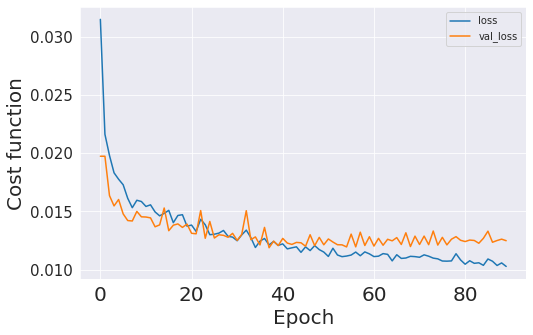

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

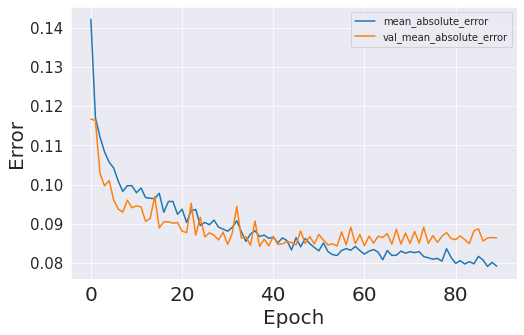

In [ ]:
#  Learning Curve

sns.set_style("darkgrid")
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.ylabel("Cost function")
plt.xlabel("Epoch")
plt.savefig('LSTM_WS2M_LOSS.png')
files.download("LSTM_WS2M_LOSS.png")
plt.show()
pd.DataFrame(history.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(8,5))
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.savefig('LSTM_WS2M_ERROR.png')
files.download("LSTM_WS2M_ERROR.png")
plt.show()

In [ ]:
# Evaluation pof MSE with the test_generator
model.evaluate(test_generator,verbose=0)

# Predictions
predictions=model.predict(test_generator)

# Consider the values of X_test by ignoring the first 14th
New_X_test=X_test[:,1:][window_length:]

# Datapredicted
df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(New_X_test)],axis=1)
# return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
rev_trans=scaler.inverse_transform(df_pred.values)

# Dysplay the prediction set
df_final=df_input[-predictions.shape[0]:]
df1=df_final['WS2M']
rev2=rev_trans[:,0]

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

# Performance metrics

mse = mean_squared_error(df1, rev2)
r2 = r2_score(df1, rev2)
mae = mean_absolute_error(df1, rev2)
# mae_scaled = mean_absolute_error(X_test[-rev2.shape[0]:,0], predictions[:,0])
mape = mean_absolute_percentage_error(df1, rev2)
print("mse=" + str(round(mse,3)))
print("r2=" + str(round(r2,3)))
print("mae=" + str(round(mae,3)))
# print("mae_scaled=" + str(round(mae_scaled,2)))
print("mape=" + str(round(mape,3)))

mse=0.134
r2=0.584
mae=0.285
mape=0.141


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

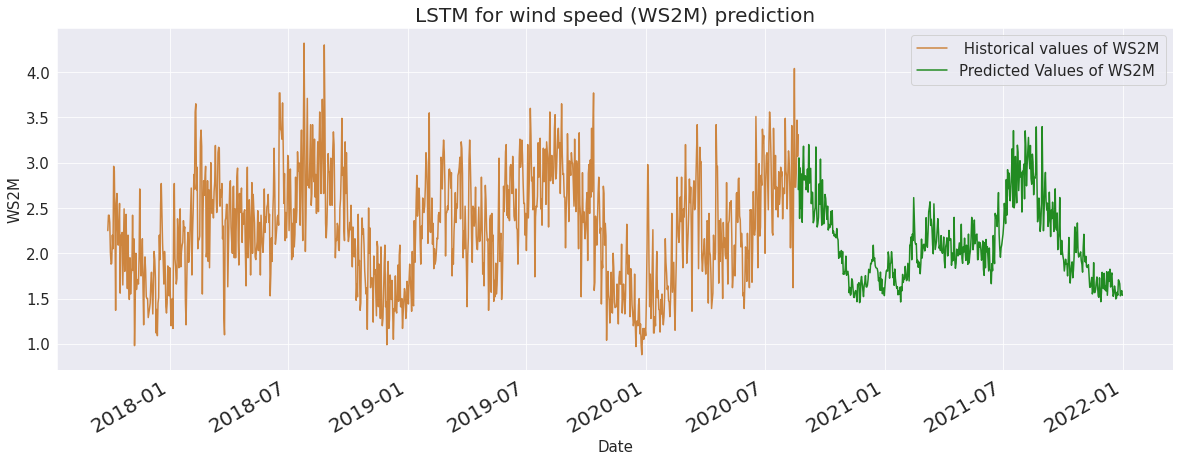

In [ ]:
from google.colab import files

# Plot of historical values and predicted values

dates = pd.date_range('08/21/2020', periods=498)
dates1 = pd.date_range('01/01/2015', periods=2060)
sns.set_style("darkgrid")
Forecast=pd.DataFrame({ 'Predicted Values of WS2M':rev2})
Forecast['date']=dates
For=Forecast.set_index('date')
T=df_input['WS2M']
D=T[0:2060].to_frame(' Historical values of WS2M')
D['Date']=dates1
DD=D.set_index('Date')
train_forecast = pd.concat([DD,For])
train_forecast[1000:2600].plot.line(figsize=(20, 7),color=['peru','forestgreen'])
plt.title("LSTM for wind speed (WS2M) prediction")
plt.ylabel("WS2M",fontsize=15)
plt.xlabel("Date",fontsize=15)

plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PRED.png')
files.download("LSTM_TMP_PRED.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

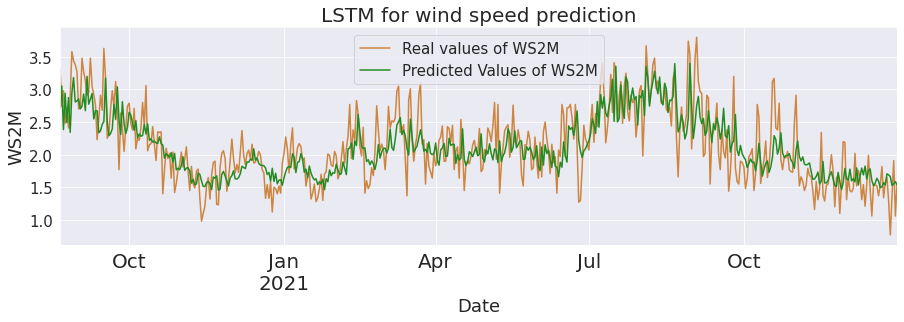

In [ ]:
# Comparison plot between LSTM prediction and the real values

sns.set_style("darkgrid")
Forecastb1=pd.DataFrame({'Real values of WS2M':df1, 'Predicted Values of WS2M':rev2})
Forecastb1['date']=dates
Forb1=Forecastb1.set_index('date')
Forb1.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.title("LSTM for wind speed prediction")
plt.ylabel("WS2M",fontsize=18)
plt.xlabel("Date",fontsize=18)
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PREDx.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()

# BIDIRECTIONAL LSTM

In [ ]:
########################################################################################################################
#####################################   Bi-LSTM model for    Wind speed prediction       ###############################
########################################################################################################################



model2= keras.Sequential()

model2.add(
    layers.Bidirectional(layers.LSTM(94, return_sequences=False), input_shape=(window_length, features_num))
)
model2.add(layers.Dense(1))
model2.summary()
# Early stopping: Model stops if the validation loss does not improve after 3 more iteration the algorithm stop
early_stopping1= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min')
model2.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
history2=model2.fit(train_generator,epochs=150,shuffle=False, validation_data=val_generator,callbacks=[early_stopping1])




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 188)              76704     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 189       
                                                                 
Total params: 76,893
Trainable params: 76,893
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
51/51 [==============================] - 5s 40ms/step - loss: 0.0290 - mean_absolute_error: 0.1367 - root_mean_squared_error: 0.1703 - val_loss: 0.0177 - val_mean_absolute_error: 0.1090 - val_root_mean_squared_error: 0.1330
Epoch 2/150
51/51 [==============================] - 1s 22ms/step - loss: 0.0212 - mean_absolute_error: 0.1165 - root_mean_squared_error: 0.1455

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

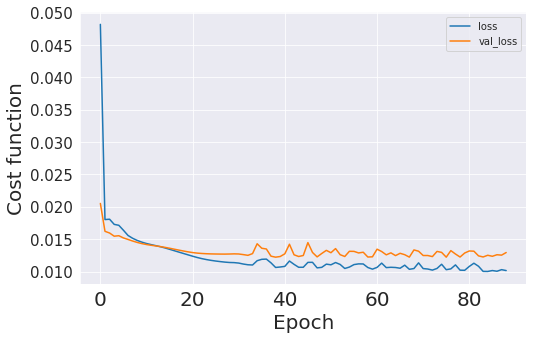

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

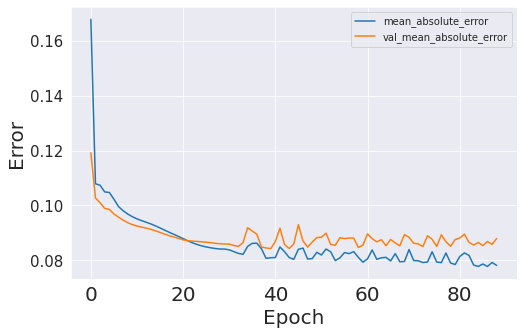

In [ ]:

# Learning Curves

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

sns.set_style("darkgrid")
pd.DataFrame(history2.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.ylabel("Cost function")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_WS2M_LOSS.png')
files.download("Bi-LSTM_WS2M_LOSS.png")
plt.show()
pd.DataFrame(history2.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(8,5))
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_WS2M_ERROR.png')
files.download("Bi-LSTM_WS2M_ERROR.png")
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

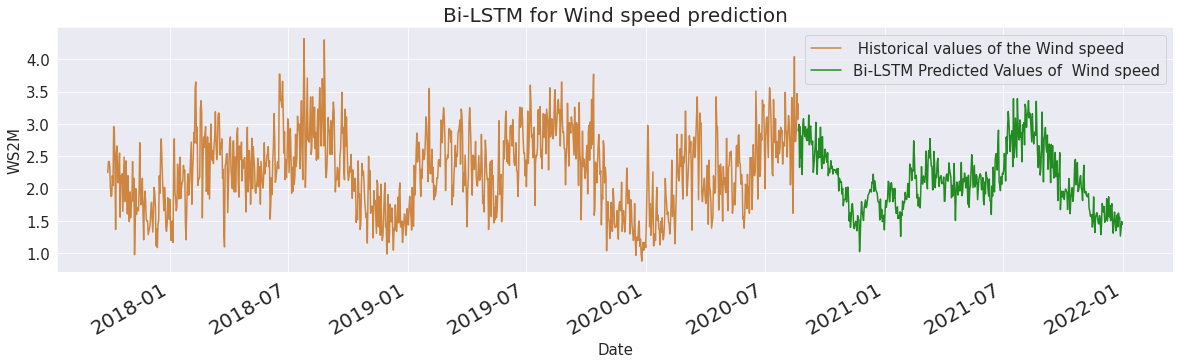

In [ ]:
# LSTM Predictions 
prediction2=model2.predict(test_generator)

# Consider the values of X_test by ignoring the first 14th
New_X_test2=X_test[:,1:][window_length:]

# Datapredicted
df_pred12=pd.concat([pd.DataFrame(prediction2),pd.DataFrame(New_X_test2)],axis=1)
# return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
rev_trans12=scaler.inverse_transform(df_pred12)

# Dysplay the prediction set
df_final12=df_input[-prediction2.shape[0]:]
df011=df_final12['WS2M']
rev022=rev_trans12[:,0]

#  Plot of historical values and predicted values

from google.colab import files
dates = pd.date_range('08/21/2020', periods=498)
dates1 = pd.date_range('01/01/2015', periods=2060)
Forecastb=pd.DataFrame({'Bi-LSTM Predicted Values of  Wind speed':rev022})
Forecastb['date']=dates
For=Forecastb.set_index('date')
T=df_input['WS2M']
D=T[0:2060].to_frame(' Historical values of the Wind speed')
D['Date']=dates1
DD=D.set_index('Date')
figsize=(35, 7)
train_forecast = pd.concat([DD,For])
sns.set_style("darkgrid")
train_forecast[1000:2600].plot.line(figsize=(20, 5),color=['peru','forestgreen'])
plt.title('Bi-LSTM for Wind speed prediction')
plt.ylabel("WS2M",fontsize=15)
plt.xlabel("Date",fontsize=15)

plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PRED.png')
files.download("LSTM_TMP_PRED.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

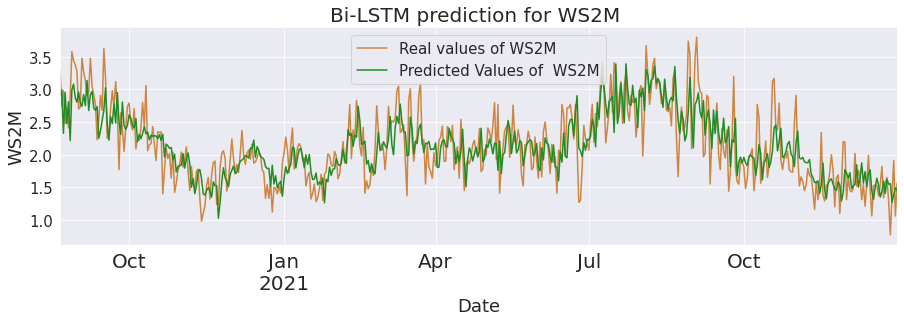

In [ ]:

# Bi-LSTM predition and real observations values

sns.set_style("darkgrid")
Forecastb1=pd.DataFrame({'Real values of WS2M':df011, 'Bi-LSTM Predicted Values of  WS2M':rev022})
Forecastb1['date']=dates
Forb1=Forecastb1.set_index('date')
Forb1.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.ylabel("WS2M",fontsize=18)
plt.xlabel("Date",fontsize=18)
plt.title("Bi-LSTM prediction for WS2M ")
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PREDx.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()


In [ ]:
# Performance metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
mse1 = mean_squared_error(df011, rev022)
r2_1 = r2_score(df011, rev022)
mae1 = mean_absolute_error(df011, rev022)
# mae1_scaled1 = mean_absolute_error(X_test[-df_pred.shape[0]:,0], prediction[:,0])
mape1 = mean_absolute_percentage_error(df011, rev022)
print("mse=",mse1)
print("r2=",r2_1)
print("mae=",mae1)
# print("mae_scaled=" + str(round(mae1_scaled1,2)))
print("mape=",mape1)


mse= 0.12835473675913384
r2= 0.6023861926689096
mae= 0.27857384409381447
mape= 0.13937723250829287
